# 03 CNN Model With Transfer Learning
This notebook was adapted from the Tensor Flow Author's Transfer Learning and Fine-tuning Tutorial Notebook, which is available here:  https://www.tensorflow.org/tutorials/images/transfer_learning .  The notebook below has been adapted for the project at hand: predicting good and bad quality food photos based on manually applied labels. 

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In this notebook, food photos are classified into two classes using a convolutional neural net.  Specifically it uses transfer learning from a pre-trained network (MobileNet V2), which was trained on a large-scale image classificaiton task.  Transfer learning seeks to take advantage of the generic feature patterns learned in the pre-trained model and apply them to a new task.  

The notebook implements both a feature extraction approach and a fine-tuning approach.  The former just adds a new classifier on top of the pre-trained model where as the fine-tuning model
unfreezes a few of the top layers in the pre-trained model and jointly trains the new layers one adds and the unfrozen top layers.  

***The notebook was built in [Google Colab](https://colab.research.google.com) using a GPU processor to improve runtime and may work best there if you choose to re-run the code.  The dataset is about 36MB.***
 
The notebook follows the general machine learning workflow.

1. Examine and learn about the data
1. Build a pipeline (in this case, using Keras ImageDataGenerator)
1. Compose the model
   * Load in the pretrained base model with existing weights
   * Add new classification layers on top
1. Train the model
1. Evaluate model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

First, the dataset is uploaded from the github repository.  In this case, the data are sets of manually labeled photos that are organized into subfolders "train" and "val", then into subfolders "good" and "bad" photos.  This will allow Tensorflow to infer the train/val sets and the class names.    

In [ ]:
_URL = 'https://github.com/jf-silverman/classy-food/raw/main/data/yelp_set3.zip'
path_to_zip = tf.keras.utils.get_file('yelp_set3.zip', origin=_URL, extract=True,  
                                      cache_dir='/content')
PATH = os.path.join(os.path.dirname(path_to_zip), 'yelp_set3')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

36585472/36574423 [==============================] - 0s 0us/step


In [ ]:
# Checking that the folders were uploaded.
!ls /content/datasets/yelp_set3/train

bad  good


In [ ]:
# If the user runs this with their own data and local hidden files are uploaded like .DS_Store or __MACOSX/, the user can remove them here.
#!rm -rf /content/datasets/<file or folder name here>

As a first step in preprocessing the training and validation datasets for Tensorflow, the batch size, target image size, interpolation method, and other parameters are given.  

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory( train_dir,
                                                            labels = 'inferred',
                                                            class_names=['bad','good'],
                                                            batch_size=16,
                                                            image_size=(224,224),
                                                            shuffle= True,
                                                            interpolation='lanczos3',
                                                            crop_to_aspect_ratio=True
                                                                        )                                                        

Found 960 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 labels = 'inferred',
                                                            class_names=['bad','good'],
                                                            batch_size=16,
                                                            image_size=(224,224),
                                                            shuffle= True,
                                                            interpolation='lanczos3',
                                                            crop_to_aspect_ratio=True
                                                            )

Found 452 files belonging to 2 classes.


Labeled images taken from the training data are viewed in sets of nine below to give some idea of the variation within and between the classes "good" and "bad".  To see view a thorough description of the criteria of the classes, see the project README.md.  Generally, the criteria are related to lighting, composition, color, focus, and presence/absence of distracting non-food items in the image.

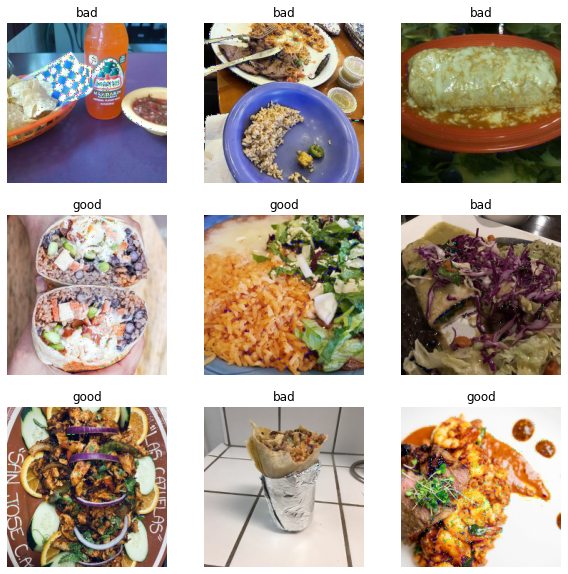

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
! mkdir -p figures
plt.savefig('figures/good_and_bad_ex1.jpg', dpi=250, format='jpg')

The original dataset doesn't contain a test set, so one is created by removing a portion of the validation data.  In this case, 20% of the data is moved.  Afterward, the number of batches in each set is printed for reference.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 24
Number of test batches: 5


### Configure the dataset for performance

Below Autotune is used.  This uses buffered prefetching to load images from disk without having I/O become blocking. More information on this can be found in Tensorflow's [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

One way to improve performance when classifying a small dataset of images is to introduce some variation by adding some flipped and rotated images.  This helps to prevent overfitting the model to the data.  You can see a tutorial about data augmentation on Tensorflow: [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).  These layers will only be active during training, not during model evaluation or model fitting.  In this example, a +/- 10% rotation and horizonal flips (mirror images) are chosen to mimick potential food photos uploaded to sites like Yelp.  

In [ ]:
#Look into how many images it generates
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate` or `Model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


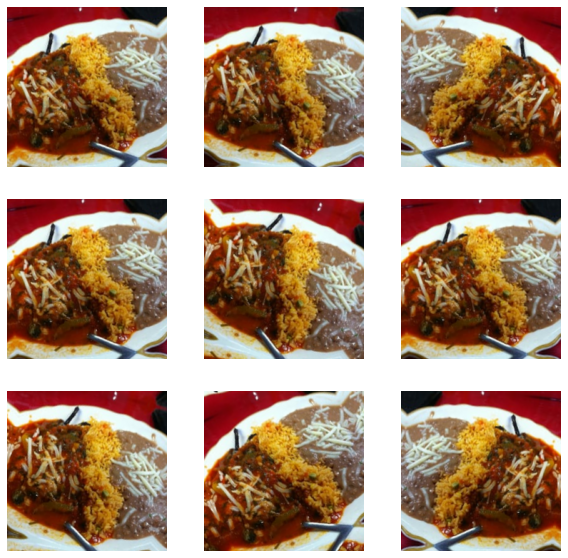

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off');
plt.savefig('figures/data_augment_ex2.jpg', dpi=250, format='jpg')

### Rescale pixel values

Different pretrained models expect pixel values in different ranges.  MobileNetV2 expects values between -1 and 1, but most jpeg photos are stored in rgb color values in range 0 to 255.  Rescaling is specified using a preprocessing method for MobileNetV2, but it can be done manually with a formula.  It is best to check the value range and methods available for the pretrained model that will be used.  A list can be found [here in Tensorflow's documentation](https://https://www.tensorflow.org/api_docs/python/tf/keras/applications).

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Manually rescaling from [0, 255] to [-1, 1]:
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Create the base model from the pre-trained convnets

MobileNet V2 is a model developed at Google using the ImageNet dataset, which contains 1.4 million photos within 1000 classes. This pre-trained model contains a wide-array of subjects, including food photos.  

In the section below, this learning is put toward the new task of food image classification.  The top layer of the model which contains specifics for the 1000 classes in ImageNet is removed. The generalized learning in the base of the model then is attached to the new classifier.  The model is instantiated with the weights used in classifying ImageNet.  In this part it is important to include the**```include_top = False```** argument so that the top layer is removed.  



In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (224,224) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In this feature extractor, each `224x224x3` image is converted into a `7x7x1280` block of features. The code below also shows how many of these blocks are in the feature batch.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


## Feature extraction
Below, the convolutional base created in the last step is frozen and used as a feature extractor.  Then the new classifier layer is added to the top to train as the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

### Adding BatchNormalization layers

Batch normalization is an important step in transfer learning.  Using, 'layer.trainable = False` during this part keeps model in inferance mode and prevents updating the mean and variance from the pre-training.  Later, when the model is unfrozen for fine-tuning, the batch normalization layers will be kept in inference mode using training = False` when calling the base model.  This keeps the model from losing the weights from the base of the pre-trained model.  More information is provided in this Tensorflow [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [ ]:
# Below is a summary of the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Add a classification head

In the next step predictions are generated by averaging over the `7x7` spatial locations using `tf.keras.layers.GlobalAveragePooling2D`.  This converts the features into a one 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


A `tf.keras.layers.Dense` layer is applied to convert features into one prediction per image.  No activation function is needed in this case because the predictions are treated as a raw prediction value (logit).  Positive numbers predict class 1 while negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, about 79% accuracy in the validation set is achieved.


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

24/24 [==============================] - 4s 53ms/step - loss: 0.8408 - accuracy: 0.4704


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.84
initial accuracy: 0.47


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
60/60 [==============================] - 58s 902ms/step - loss: 0.7656 - accuracy: 0.5031 - val_loss: 0.7053 - val_accuracy: 0.5403
Epoch 2/10
60/60 [==============================] - 48s 788ms/step - loss: 0.7052 - accuracy: 0.5490 - val_loss: 0.6669 - val_accuracy: 0.5591
Epoch 3/10
60/60 [==============================] - 48s 782ms/step - loss: 0.6695 - accuracy: 0.5823 - val_loss: 0.6267 - val_accuracy: 0.6022
Epoch 4/10
60/60 [==============================] - 48s 797ms/step - loss: 0.6324 - accuracy: 0.6229 - val_loss: 0.6025 - val_accuracy: 0.6210
Epoch 5/10
60/60 [==============================] - 49s 799ms/step - loss: 0.6239 - accuracy: 0.6292 - val_loss: 0.5858 - val_accuracy: 0.6263
Epoch 6/10
60/60 [==============================] - 48s 786ms/step - loss: 0.6215 - accuracy: 0.6417 - val_loss: 0.5631 - val_accuracy: 0.6452
Epoch 7/10
60/60 [==============================] - 48s 785ms/step - loss: 0.5777 - accuracy: 0.6510 - val_loss: 0.5509 - val_accuracy: 0.6774

In [ ]:
#model.save('mobilenet_base_model')

### Learning curves

The learning curves below show how accuracy and loss improve in both training and validation set over epochs when using the MobileNetV2 base model as a fixed feature extractor.

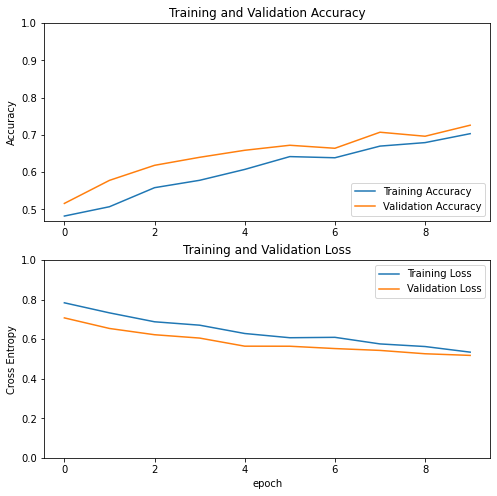

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('figures/mobilenet_base_eval_figs.jpg',dpi=200,format='jpg')
plt.show()

After about 8 epochs, train and test scores come close to converging, with a validation accuracy of about 73-79%. Fine-tuning in the next step may increase the scores a bit.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
60/60 [==============================] - 13s 123ms/step - loss: 0.5093 - accuracy: 0.7437 - val_loss: 0.4584 - val_accuracy: 0.7608
Epoch 11/20
60/60 [==============================] - 7s 112ms/step - loss: 0.4098 - accuracy: 0.7979 - val_loss: 0.4372 - val_accuracy: 0.7903
Epoch 12/20
60/60 [==============================] - 7s 111ms/step - loss: 0.3812 - accuracy: 0.8146 - val_loss: 0.4081 - val_accuracy: 0.8333
Epoch 13/20
60/60 [==============================] - 7s 113ms/step - loss: 0.3408 - accuracy: 0.8375 - val_loss: 0.4049 - val_accuracy: 0.8253
Epoch 14/20
60/60 [==============================] - 7s 113ms/step - loss: 0.3011 - accuracy: 0.8552 - val_loss: 0.4055 - val_accuracy: 0.8145
Epoch 15/20
60/60 [==============================] - 7s 113ms/step - loss: 0.3072 - accuracy: 0.8625 - val_loss: 0.3707 - val_accuracy: 0.8387
Epoch 16/20
60/60 [==============================] - 7s 111ms/step - loss: 0.2771 - accuracy: 0.8646 - val_loss: 0.4141 - val_accuracy: 0.784

In [ ]:
#model.save('mobilenet_trainable')

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model, accuracy reaches about 83% on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

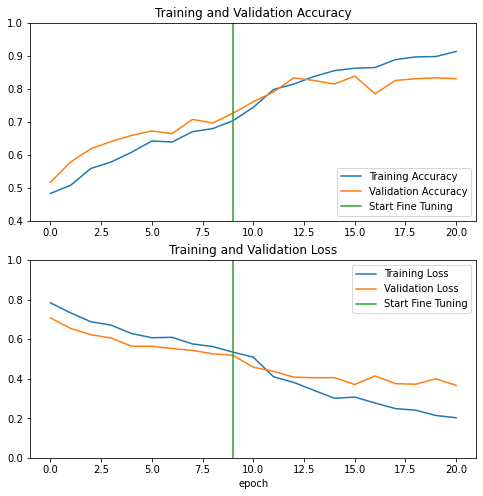

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('figures/mobilenet_trainable_figs.jpg',dpi=200,format='jpg')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 1s 80ms/step - loss: 0.4521 - accuracy: 0.8000
Test accuracy : 0.800000011920929


Reviewing batches of the test dataset, one can get a sense for which photos the model predicts well and which ones were misclassified.  

Predictions:
 [1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0]
Labels:
 [1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0]


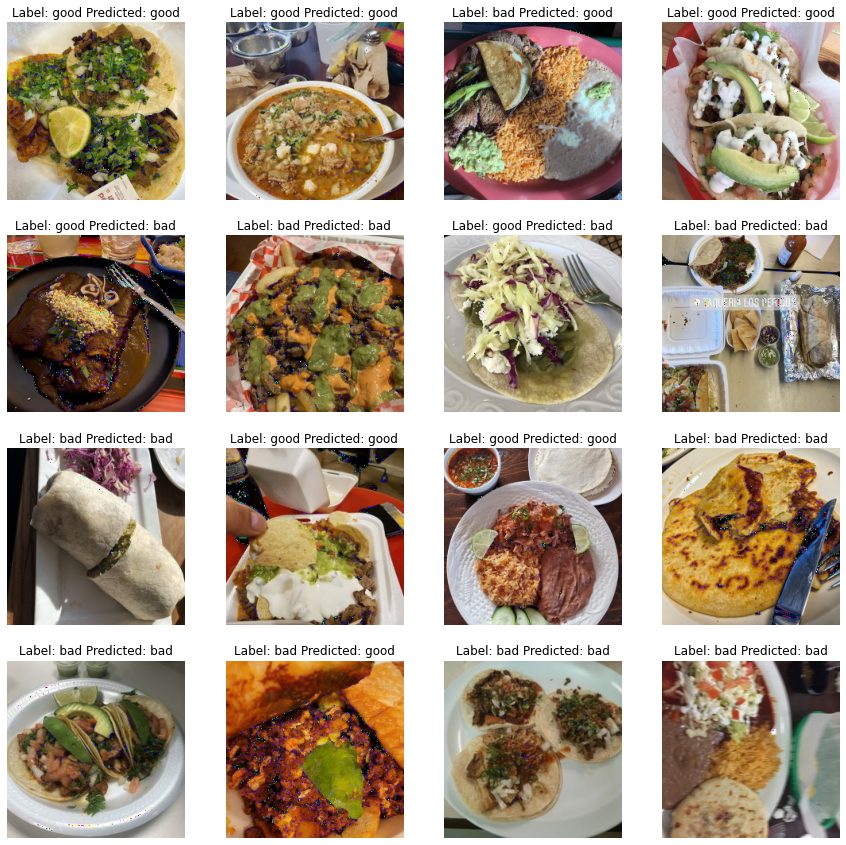

In [52]:
# Class 0 is Bad, Class 1 is Good
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('Label: ' + class_names[label_batch[i]] + ' ' + 'Predicted: ' + class_names[predictions[i]])
  plt.axis("off")
  plt.savefig('mobilenet_preds_vs_label06.jpg',dpi=250,format='jpg')

A confusion matrix can be generated for the batch after the image grid batch is generated above. It appears a few photos were mis-labeled in the orginal process.  Results, conclusions and recommendations are discussed in the README.md file.

In [53]:
tf.math.confusion_matrix( labels=label_batch, predictions= predictions)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[7, 2],
       [2, 5]], dtype=int32)>

Below is some additional code that is not yet working.

In [ ]:
test_labels = np.array([label.numpy() for example, label in test_dataset]).flatten()

In [ ]:
test_labels

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int32)

In [ ]:
test_preds = model.predict(test_dataset).flatten()
test_preds

array([  2.1959474 ,  -2.2917373 ,  -0.09647097,  -2.3840845 ,
        -2.930981  ,   7.5042467 ,  -0.04462263,   1.2166065 ,
         9.2809515 ,  -7.6018305 ,  -1.4898471 ,   0.06722662,
         8.760782  , -10.766338  ,  -0.39148706,  -0.01908635,
        -2.921372  ,  -1.1116589 ,  -2.0208292 ,   7.063989  ,
        -5.4983277 ,  -2.0939064 , -10.48112   ,   8.195594  ,
         2.8227098 ,   6.1781383 ,   7.1164904 ,   5.642123  ,
         7.6378193 ,   9.499719  ,  -2.2046876 ,  -0.4989303 ,
        -6.9016685 ,   2.6144047 ,   7.5690427 ,  -5.010708  ,
         7.3757124 ,   9.453085  ,  -1.4077506 ,   3.30167   ,
        -3.2365344 , -10.719192  ,  -2.463429  ,  -1.7065977 ,
        -8.438242  ,   2.5171785 ,   3.161523  ,  -3.7783394 ,
         2.5470686 ,   2.2313132 ,   1.4123509 ,   6.459506  ,
         2.8474026 ,   5.823559  ,   1.5125273 ,  -4.6268644 ,
       -11.31675   ,  -3.921037  ,   0.26073807,  -9.340706  ,
         6.247888  ,   4.7675376 ,  -7.5625706 ,  -4.73

In [ ]:
# Apply a sigmoid since our model returns logits
# test_preds = tf.nn.sigmoid(test_preds)
# np.round(test_preds,4)

array([0.5001, 0.7199, 0.5292, 0.5127, 0.5459, 0.7218, 0.7299, 0.5274,
       0.7291, 0.7125, 0.7198, 0.6093, 0.5   , 0.5196, 0.6264, 0.731 ,
       0.731 , 0.549 , 0.7283, 0.5017, 0.7307, 0.5045, 0.6168, 0.5211,
       0.731 , 0.7309, 0.6213, 0.7302, 0.5933, 0.731 , 0.6376, 0.5   ,
       0.5575, 0.5001, 0.5   , 0.6838, 0.7284, 0.731 , 0.6482, 0.5036,
       0.5001, 0.7253, 0.7309, 0.5001, 0.5   , 0.7261, 0.5468, 0.7109,
       0.7304, 0.5   , 0.5031, 0.5049, 0.7238, 0.7308, 0.5003, 0.5   ,
       0.731 , 0.7174, 0.7144, 0.731 , 0.7294, 0.731 , 0.5466, 0.7301,
       0.731 , 0.5   , 0.7281, 0.5497, 0.5002, 0.5115, 0.7179, 0.5248,
       0.731 , 0.7007, 0.731 , 0.7307, 0.544 , 0.7127, 0.731 , 0.5002],
      dtype=float32)

In [ ]:
test_preds = tf.where(test_preds < 0, 0, 1)
test_preds

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1], dtype=int32)>

In [ ]:
test_preds[:5]

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 0, 0, 0, 0], dtype=int32)>

In [ ]:
test_labels[:5]

array([0, 1, 1, 1, 1], dtype=int32)

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


In [ ]:
test_img_list = []
test_label_list = []

In [ ]:
tes_img_list.append, test_label_list.append = test_dataset.as_numpy_iterator().next()
test_label_list

NameError: ignored

In [ ]:
predictions = model.predict_on_batch(image_batch).flatten()